# Homework 3

### Preliminaries

In [1]:
import os
import pandas as pd
import json
import folium
import seaborn
import matplotlib.pyplot as plt
from branca.colormap import linear
import branca.colormap as cm
from IPython.display import HTML


## Task 1

Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

### Assumptions:
Since we could not find data for all European countries that are listed in the europe.topojson.json file we added them manually and set the the value for the unemployment rate to -1 so that they could be easily distinguish in the choropleth map.
On the eurostat website we could choose different definitions for the unemployment rate:
Percentage of active population
Percentage of total population
We choosed the first one since it is more interestign to know how many unemployed there is compared to the total amount of people that are able to work. The second ratio could be skewed for countries with high numbers of children, lower retirement ages or higher life expectancies.

We use the data are from 2016 as we want to avoid sensitivity to seasona variations.

In [2]:
#We load the json file from it's path
eu_geo = os.path.join('', 'topojson/europe.topojson.json')
eu_geo_json = json.load(open(eu_geo))
#Read the csv file over unemployment data from eurostat and save in a dataframe.
eu_unemployment = os.path.join('', 'eurostat.csv')
eu_data = pd.read_csv(eu_unemployment)
# Keep only the interesting coulmns
eu_data = eu_data[['GEO', 'Value']]
# Get dictionarie in the json file that are of intrest: country id, name etc.
info =eu_geo_json['objects']['europe']['geometries']

name = pd.DataFrame({'id':[],
                    'Name':[]})
series = []
series1 = []
# Get the id and name of the countries in the json file and save to a dataframe
for a in info:
    series.append(a['id'])
    series1.append(a['properties'])
name.id = series 
name.Name = series1

#There are two id that differ in the two dataframe(Greece and Great Britain) and therefore we change the on in the 
#eurostat file so that is the same as in the json file.
eu_data.loc[27,'GEO'] = 'GB'
eu_data.loc[7,'GEO'] = 'GR'
#Add the missing countries to the dataframe over unemployment ration and set the ratio to -1 so that is easily 
#distinguishable. Since we are supposed to compare the Swiss data with the other european countries we ad the data for 
# Switzerland manully. We found from amstat that the unemployment ratio for Switzerland 2016 is 4.7 %.
eu_data.columns = ['id','Unemployment_rate']
data = pd.DataFrame({'id':['CH','AZ','AL','AM','BA','GE','IL','BY','LI','MK','FO','AD','MC','ME','MD','UA',
                           'SM','RS','VA','RU'],
                     'Unemployment_rate':[4.7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]})

eu_data = eu_data.append(data)
eu_data = eu_data.sort_values(by = 'Unemployment_rate')


In [3]:
#Creat a folium map
eu_map = folium.Map(location=[46.519962, 6.633597], zoom_start=3)
# We choosed to use colormap as our choropleth plot, we choose white for the countries that has no data over 
# the unemployment ratio and the a graded scale from light red to darker red and then blue.
d1 = ['white','red','violet','orange','indigo','yellow','blue']
d2 =['white','yellow','orange','red','purple','blue']
linear = cm.LinearColormap(d2, vmin=-1, vmax=23)
linear = linear.to_step(n=100,data = [-1,0,1,2,3,4,5,6,7,8,9, 10, 11, 12.9, 19, 23],method='quantiles',round_method='int')

linear.caption = 'Unemployment rate'

eu_dict = eu_data.set_index('id')['Unemployment_rate']

eu_map = folium.Map([46.519962, 6.633597], tiles='cartodbpositron', zoom_start=3)

folium.TopoJson( open('topojson/europe.topojson.json'),
                 'objects.europe',
                style_function=lambda feature: {
        'fillColor':linear(eu_dict[feature['id']]),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(eu_map)
linear.add_to(eu_map)

eu_map.save('european_map.html')
HTML('<iframe src=./european_map.html width=1000 height=500></iframe>')


### Discussion

We choosed to split  colorplot into small intervals. The countries with now data are marked as white and then we have a spilt the dataclasses into diffrent intervals where the value of the diffrent colors are stated. The colors change from more light to darker as the unemployment rate increases. 

If we compare the Swiss unemployment data to the rest of Europe we find that it is similar to the northern countries which is as expected since the have similar economies and wealth.

## Task 2
Go to the amstat website (https://www.amstat.ch/v2/index.jsp) to find a dataset that includes the unemployment rates in Switzerland at a recent date.

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

## Our analysis for Task 2
    
On the amstat website (https://www.amstat.ch/v2/index.jsp) one can actually find various different unemployment rates. In the folowing JS stands for jobseekers (people looking for a job who are unemployed or employed) and UE stands for unemployed people (people out of work who are seeking a job).

In order to complete the above task and perform a comparison we will analyse the total numbers and rates for JS and UE. We take the rates directly from suitable data sets provided by Amstat, rather than inferring them. 

#### A dictionary for the canton_id

We start by creating a dictionary that links the canton's name to the ID used inside the ch_canton topojson file. The order is taken directly from the topojson file. This allows us to link our data correctly to the map.

In [4]:
canton_id = {"Zuerich" : "ZH", 
    "Bern" : "BE", 
    "Luzern" : "LU", 
    "Uri" : "UR", 
    "Schwyz" : "SZ", 
    "Obwalden" : "OW", 
    "Nidwalden" : "NW", 
    "Glarus" : "GL", 
    "Zug" : "ZG", 
    "Freiburg" : "FR", 
    "Solothurn" : "SO", 
    "Basel-Stadt" : "BS", 
    "Basel-Landschaft" : "BL", 
    "Schaffhausen" : "SH", 
    "Appenzell Ausserrhoden" : "AR", 
    "Appenzell Innerrhoden" : "AI", 
    "St. Gallen" : "SG", 
    "Graubuenden" : "GR", 
    "Aargau" : "AG", 
    "Thurgau" : "TG", 
    "Tessin" : "TI", 
    "Waadt" : "VD", 
    "Wallis" : "VS", 
    "Neuenburg" : "NE", 
    "Genf" : "GE", 
    "Jura" : "JU"}

#### Creating the data frame

We read our data into a data frame, select approriate columns, translate names and add additional columns (jobseekers rate and the portion of unemployed amongst the jobseekers).

In [5]:
mb2 = pd.read_csv("monthly_unemployment_no_umlaut.csv", header = [1,3] )
# Isolating the total numbers (sum of monthly rates)
mb2 = mb2['Kanton'].merge(mb2['Gesamt'], left_index = True, right_index = True)
# Translating the column names
mb2.columns = ['Canton', 'UE_rate', 'registered_UE', 'registered_JS', 'JS_with_work']
# Adding a column with the canton_id for each canton
mb2['Canton_id'] = mb2['Canton'].map(canton_id)
# Reducing the data frame to the columns we use later
mb2 = mb2[['Canton', 'Canton_id', 'UE_rate', 'registered_UE', 'registered_JS']]

# Note our columns still display the annual sums of monthly values.
# We create monthly averages and round them to the closest integer.
mb2[['registered_UE', 'registered_JS']] = mb2[['registered_UE', 'registered_JS']]/12
mb2 = mb2.round({'registered_UE':0, 'registered_JS':0})
mb2.registered_UE = mb2.registered_UE.astype(int)
mb2.registered_JS = mb2.registered_JS.astype(int)

#### 2 different statistics

In task 2 it was observed that there are different statistics. Here we ahve been looking at two. One takes into account all people seeking a job (JS), while the other only considers people who are unemployed (UE). The job seeker data counts people who are working while looking for a job. The discrepancies between UE and JS vary from canton to canton. 

In order to gain a better insight we look at the proportion of job seekers in each canton who are actually unemployed. We then rank the cantons in descening order according to this proportion.

In [6]:
# We define the rate of jobseekers and the proportion of unemployed amongst jobseekers
mb2['JS_rate'] = (mb2.UE_rate * mb2.registered_JS / mb2.registered_UE).round(1)
mb2['UE_percentage'] = ((100*mb2.registered_UE / mb2.registered_JS).round(0) ).astype(int)
# reordering columns 
mb2 = mb2[['Canton', 'Canton_id', 'registered_UE','UE_rate',  'registered_JS', 'JS_rate', 'UE_percentage']]
# We sort the cantons by their portion of unemployment 
mb2_sort_ratio = mb2.sort_values('UE_percentage', ascending=False)
mb2_sort_ratio

,Canton,Canton_id,registered_UE,UE_rate,registered_JS,JS_rate,UE_percentage
0,Zuerich,ZH,30084,3.7,36786,4.5,82
24,Genf,GE,12965,5.5,16593,7.0,78
12,Basel-Landschaft,BL,4445,3.0,5859,4.0,76
1,Bern,BE,15283,2.7,20084,3.5,76
23,Neuenburg,NE,5365,5.8,7170,7.8,75
18,Aargau,AG,11484,3.2,15976,4.5,72
21,Waadt,VD,18741,4.7,26238,6.6,71
26,Gesamt,NaN,149317,3.3,211097,4.7,71
11,Basel-Stadt,BS,3832,3.9,5502,5.6,70
25,Jura,JU,1695,4.6,2415,6.6,70


#### Observation

The 4 cantons with the highest proportion of unemployed amongst jobseekers are also the ones containing the 4 biggest cities in Switzerland or their periphery (Basel-Landschaft). This suggest that larger cities have proportionally fewer people looking for a new job while still being employed. In contrast, in rural areas people are more actively looking for jobs while they have a job. 

One reason for this phenomena might be that rural and mountainous areas have a higher portion of seasonal and short term employments in the agricultural sector and tourism. Hence people actively look ahead for the next opportunity, or get registered when they are switching jobs between seasons.


### The map

In [23]:
# We want to make sure we centre our map correctly so that all parts are clearly displayed. 
# Hence we calculate the midpoint of Switzerland by using the coordinates of geographical extreme points 
# (https://en.wikipedia.org/wiki/List_of_extreme_points_of_Switzerland)
lat_N = 47.8
lat_S = 45.8
long_W = 5.0
long_E = 11.5
lat_centre = 0.5*lat_N  + 0.5*lat_S
long_centre = 0.5*long_W + 0.5*long_E 
CH_centre_coord = [lat_centre, long_centre]

# Overlaying geojson info
# canton_geo_path = r'topojson/ch-cantons.topojson.json'
# geo_json_data = json.load(open(canton_geo_path))


#Create Swiss map with unemployment data

d3 =['yellow','orange','red','purple','blue']
colormap0 = cm.LinearColormap(d3, vmin=-1, vmax=23)
colormap0 = colormap0.to_step(n=100,data = [0,0.6,1.3,1.9,2.6,3.2,3.8,4.5,5.1,5.7],method='quantiles',round_method='int')
colormap0.caption = 'Unemployment rate'

ch_dict = mb2[:26].set_index('Canton_id')['UE_rate']

# Creation of the map 
ch_map = folium.Map(CH_centre_coord, tiles='cartodbpositron', zoom_start=7)

# Layer over the map to represent the unemployment rate
folium.TopoJson( open('topojson/ch-cantons.topojson.json'),
                 'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap0(ch_dict[feature['id']]),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(ch_map)
colormap0.add_to(ch_map)

ch_map.save('swiss_map.html')

In [25]:
print('A map displaying the unemployment rates for each canton.')

HTML('<iframe src=./swiss_map.html width=800 height=400></iframe>')

A map displaying the unemployment rates for each canton.


#### Discussion of our choropleth map

We can clearly see a trend from east to west of the unemployment rates rising and being highest in the French speaking part.

## Task 3 
Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

#### Creating the data frames

We use the unemployment rates distinguishing foreigners and Swiss nationals for 2016 instead of the September 2017 data. Our reason is that we can obtain the yearly average for 2016 and hence our data is not being affected by seasonal variations (e.g. harvest season in September).

We read the unemployment data into a data frame and select the desired columns. We also translate column labels and the options for the column 'Nationality'.

In [8]:
mb = pd.read_csv('average_unemploment_rate_by_year.csv')
# Assigning English column names
mb.columns = ['Year', 'Canton', 'Nationality', 'average_number_of_unemployed', 'unemployment_rate',
              'average_number_of_unemployed_youth', 'unemployment_rate_youth', 
              'average_number_of_unemployed_50+', 'unemployment_rate_50+']
# Adding a column with the canton_id for each canton
mb['Canton_id'] = mb['Canton'].map(canton_id)
# We make a copy of our data frame for later use.
mb_full = mb.copy()

# Returnign to the original dataframe we reduce it to the columns we use later
mb = mb[['Canton', 'Canton_id', 'Nationality', 'average_number_of_unemployed', 'unemployment_rate']]
# In the nationality column we translate 'Auslaender' to 'Foreign' and 'Schweizer' to 'Swiss'.
mb.loc[(mb['Nationality']=='Auslaender'), 'Nationality'] = 'Foreign'
mb.loc[(mb['Nationality']=='Schweizer'), 'Nationality'] = 'Swiss'

### Data by nationality (aka the Swiss vs the rest of the world)

We separate our data frame into two frames according to the nationality criteria.

In [9]:
mb_Swiss = mb[(mb.Nationality == "Swiss")]
mb_Foreign = mb[(mb.Nationality == "Foreign")]
mb_Swiss

,Canton,Canton_id,Nationality,average_number_of_unemployed,unemployment_rate
1,Zuerich,ZH,Swiss,16381,2.8
3,Bern,BE,Swiss,9491,2.0
5,Luzern,LU,Swiss,2691,1.5
7,Uri,UR,Swiss,95,0.6
9,Schwyz,SZ,Swiss,833,1.2
11,Obwalden,OW,Swiss,119,0.7
13,Nidwalden,NW,Swiss,177,0.8
15,Glarus,GL,Swiss,268,1.6
17,Zug,ZG,Swiss,867,1.8
19,Freiburg,FR,Swiss,2465,1.9


We start by generating a map of the unemployment rate for the Swiss nationals.

In [10]:

d3 =['yellow','orange','red','purple','blue']
colormap1 = cm.LinearColormap(d3, vmin=-1, vmax=5)
colormap1 = colormap1.to_step(n=100,data = [0,0.6,1.3,1.9,2.6,3.2,3.8,4.9],method='quantiles',round_method='int')

colormap1.caption = 'Unemployment rate for Swiss nationals'

ch_dict_Swiss = mb_Swiss[:26].set_index('Canton_id')['unemployment_rate']

# Creation of the map 
Swiss_UE_map = folium.Map(CH_centre_coord, tiles='cartodbpositron', zoom_start=7.7)

# Layer over the map to represent the unemployment rate
folium.TopoJson( open('topojson/ch-cantons.topojson.json'),
                 'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap1(ch_dict_Swiss[feature['id']]),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(Swiss_UE_map)
colormap1.add_to(Swiss_UE_map)

Swiss_UE_map.save('Swiss_UE_map.html')

Now we generate a map of the unemployment rate for the foreign nationals. We purposefully redefine colormap and colormap.caption under the same name using the maximum unemployment rate for foreighn nationals. This renders the Swiss map colours corresponding to low unemployment (redish tones for us) making them stand out against the bluer tones generated by foreign nationals.

In [11]:
d3 =['yellow','orange','red','purple','blue']
colormap2 = cm.LinearColormap(d3, vmin=0, vmax=10.6)
colormap2 = colormap2.to_step(n=100,data = [0,1,2,3,4,5,6,7,8,9,10,11],method='quantiles',round_method='int')
colormap2.caption = 'Unemployment rate for Swiss and foreign nationals'

ch_dict_Foreign = mb_Foreign[:26].set_index('Canton_id')['unemployment_rate']

# Creation of the map 
Foreign_UE_map = folium.Map(CH_centre_coord, tiles='cartodbpositron', zoom_start=7)

# Layer over the map to represent the unemployment rate
folium.TopoJson( open('topojson/ch-cantons.topojson.json'),
                 'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap2(ch_dict_Foreign[feature['id']]),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(Foreign_UE_map)
colormap2.add_to(Foreign_UE_map)

Foreign_UE_map.save('Foreign_UE_map.html')

In [26]:
print('A map displaying the unemployment rates for Swiss nationals for each canton. ')

HTML('<iframe src=./Swiss_UE_map.html width=1000 height=600></iframe>')


A map displaying the unemployment rates for Swiss nationals for each canton. 


In [27]:
print('A map displaying the unemployment rates for foreign nationals for each canton. ')

HTML('<iframe src=./Foreign_UE_map.html width=1000 height=600></iframe>')



A map displaying the unemployment rates for foreign nationals for each canton. 


#### Discussion of our choropleth map

For the Swiss nationals we observe the same trend from east to west of the unemployment rates rising and being highest in the French speaking part that we observed before. For the foreign nationals the trend is more one from inside to outside.

The co

### Data by age groups

We return to the original dataframe and analyse the data for age groups. 

We have two options: 1) Obtaining data in 5 year bins; or 2) grouping the data as Youth (15-24), Middle age (25-49) and Seniors (50+). The first option captures more nuances. However the second is quite frequently used. The group 'Youth' captures the majority of people who are in some form of education while the group 'Seniors' highlights those people for whom retraining or a career change will be more difficult. We will use the second approach as it is rich enough to capture key differences between age groups and it will render our graphs less crowded.

Below we isolate 4 key rates: 1) overall unemployment (UE); 2) youth (Y); 3) middle age (MA); and 4) seniors (S). Rates 1), 2) and 4) are given. In order to calculate rate 3) - the unemployment rate for middle age - we first calculate the total number of unemployed people in this age bracket and then derive the corresponding rate. We note that the numbers will contain inaccuracies due rounding errors. (Comment: Ideally we would use the number of all people able to work. This number was not found in the Amstat database, and the use of external sources could lead to inconsistencies due to differences in the underlying definitions.) 

In [14]:
# Translating the nationality categories again
mb_full.loc[(mb_full['Nationality']=='Auslaender'), 'Nationality'] = 'Foreign'
mb_full.loc[(mb_full['Nationality']=='Schweizer'), 'Nationality'] = 'Swiss'

# In the following section we define several auxillary variables, before calculating
# the unemployment rate for the middle age group.
# We start by calculcating the total number of middle aged unemployed
mb_full['average_number_of_unemployed_MA'] = (mb_full['average_number_of_unemployed'] - mb_full['average_number_of_unemployed_youth'] - mb_full['average_number_of_unemployed_50+'])
# For the rate of middle aged unemployed we need to first work out 
# the total number of middle aged people with in the active (working) population.
# For this we need the total active population as well as the active youth and senior population
mb_full['Active_pop'] = 100*mb_full['average_number_of_unemployed']/mb_full['unemployment_rate']
mb_full['Y_active_pop'] = 100*mb_full['average_number_of_unemployed_youth']/mb_full['unemployment_rate_youth']
mb_full['S_active_pop'] = 100*mb_full['average_number_of_unemployed_50+']/mb_full['unemployment_rate_50+']
# The active middle aged population is obtained by the difference
mb_full['MA_active_pop'] = mb_full.Active_pop - mb_full.Y_active_pop - mb_full.S_active_pop
# Finally we calculate the unemployment rate for the middle age group
mb_full['MA_rate'] = (100*mb_full.average_number_of_unemployed_MA / mb_full.MA_active_pop).round(1)
mb_full['MA_rate']


# We create a dataframe that only contains the 4 rates mentioned above
mb_rate = mb_full[['Canton', 'Canton_id', 'Nationality', 'unemployment_rate', 'unemployment_rate_youth', 'MA_rate', 'unemployment_rate_50+']]
mb_rate.columns = ['Canton', 'Canton_id', 'Nationality', 'UE_rate', 'Y_rate', 'MA_rate', 'S_rate']

We separate our data frame into two frames according to the nationality criteria again.

In [15]:
mb_rate_Foreign = mb_rate[(mb_rate.Nationality == "Foreign")]
mb_rate_Swiss = mb_rate[(mb_rate.Nationality == "Swiss")]

### Ploting of rates for youth, middle age and senior

We compare the different unemployment rates for age groups by plotting a bar plot for each age group. We do this for the Swiss first and then for foreign nationals. The y-axis has been chosen differently for teh tow nationalities in order to make comparisons within each family meaningful.

#### Swiss nationals 

The following 3 plots show the unemployment rate for each canton in percentage for Swiss nationals for youth (15-24), middle age (25-49) and seniors (50+). The y-axis has been scaled from 0 to 6.

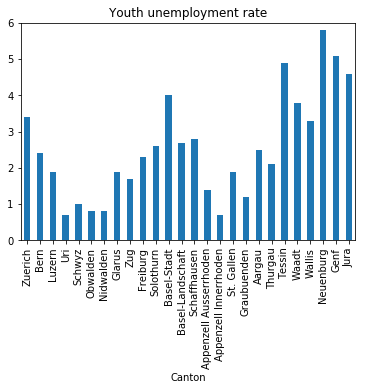

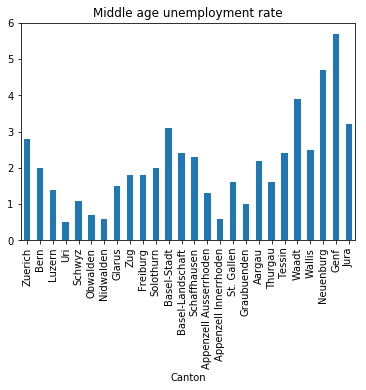

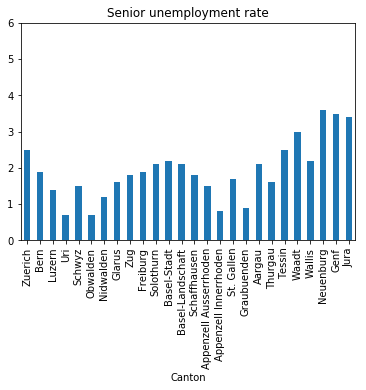

In [16]:
mb_rate_Swiss.plot(x = 'Canton', y = 'Y_rate', kind = 'bar', legend = False, title = 'Youth unemployment rate', ylim = [0,6])
plt.show()
mb_rate_Swiss.plot(x = 'Canton', y = 'MA_rate', kind = 'bar', legend = False, title = 'Middle age unemployment rate', ylim = [0,6])
plt.show()
mb_rate_Swiss.plot(x = 'Canton', y = 'S_rate', kind = 'bar', legend = False, title = 'Senior unemployment rate', ylim = [0,6])
plt.show()

#### Foreign nationals 

The following 3 plots show the unemployment rate for each canton in percentage for foreign nationals for youth (15-24), middle age (25-49) and seniors (50+). The y-axis has been scaled from 0 to 15.

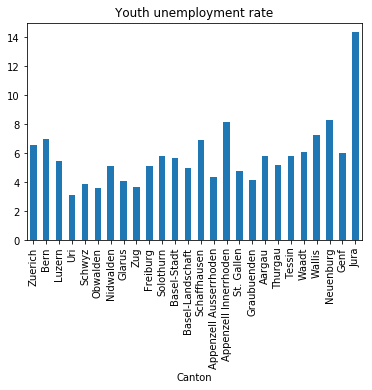

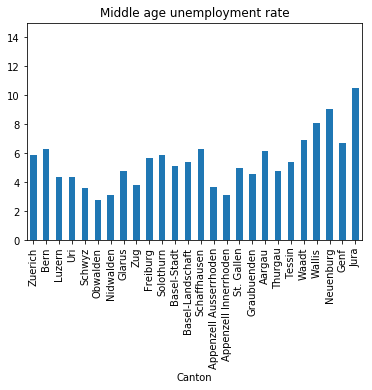

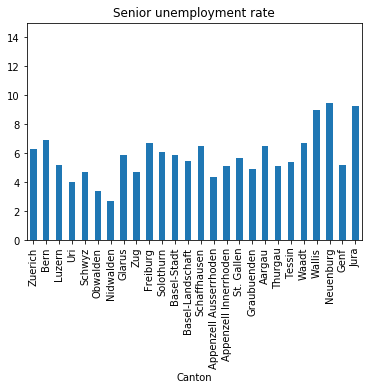

In [17]:
mb_rate_Foreign.plot(x = 'Canton', y = 'Y_rate', kind = 'bar', legend = False, title = 'Youth unemployment rate', ylim = [0,15])
plt.show()
mb_rate_Foreign.plot(x = 'Canton', y = 'MA_rate', kind = 'bar', legend = False, title = 'Middle age unemployment rate', ylim = [0,15])
plt.show()
mb_rate_Foreign.plot(x = 'Canton', y = 'S_rate', kind = 'bar', legend = False, title = 'Senior unemployment rate', ylim = [0,15])
plt.show()

## Task 4
BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

Analysis: We sort the cantons by their unemployment rate and look for the highest 10 rates amongst Swiss workers and foreigners.

In [18]:
mb_rate_Swiss_sort = mb_rate_Swiss.sort_values('UE_rate', ascending=False)
mb_rate_Swiss_sort = mb_rate_Swiss_sort[['Canton', 'UE_rate']]
print('The 10 cantons with the highest unemployment rate for Swiss nationals:')

mb_rate_Swiss_sort.head(10)

The 10 cantons with the highest unemployment rate for Swiss nationals:


,Canton,UE_rate
49,Genf,4.9
47,Neuenburg,4.5
43,Waadt,3.6
51,Jura,3.5
23,Basel-Stadt,2.9
1,Zuerich,2.8
41,Tessin,2.7
45,Wallis,2.5
25,Basel-Landschaft,2.3
27,Schaffhausen,2.2


In [19]:
mb_rate_Foreign_sort = mb_rate_Foreign.sort_values('UE_rate', ascending=False)

print('The 10 cantons with the highest unemployment rate for foreign nationals:')
mb_rate_Foreign_sort = mb_rate_Foreign_sort[['Canton', 'UE_rate']]
mb_rate_Foreign_sort.head(10)

The 10 cantons with the highest unemployment rate for foreign nationals:


,Canton,UE_rate
50,Jura,10.6
46,Neuenburg,9.1
44,Wallis,8.2
42,Waadt,6.8
2,Bern,6.5
26,Schaffhausen,6.4
48,Genf,6.3
36,Aargau,6.2
0,Zuerich,6.0
20,Solothurn,5.9


A direct look at the table shows that the French speaking cantons, which lie to the West of the Röstigraben, dominate the top 4 spots of both tables and in some cases clearly separate themselves from the following cantons. While the Wallis is in 8th for the Swiss nationals and Geneva is in 7th for the foreign nationals, we still have a clear trend for the French speaking cantons. Taking the average rank from both tables would give all 5 French speaking cantons at the top.